# FINISHED. FORSE METTI SPIEGAZIONI

## Lab 6: Intrinsic Dimension and Density Estimation
You can use external libraries for linear algebra operations but you are expected to write your own algorithms.

# Exercise 1
Using the ```dry_beans_dataset``` as we did in previous laboratories (ie. follow the same proprocessing steps), program your own implementation of the two-NN estimate for the Intrinsic Dimension. 

Is the result comparible with what you would expect from an analysis of PCA's spectrum?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder

In [2]:
df = pd.read_excel("../Datasets/Dry_Bean_Dataset.xlsx")

y = df['Class']
X = df.drop('Class', axis=1)

encoder = OrdinalEncoder()
y=np.array(y)
encoder.fit(y.reshape(-1,1))
y = encoder.transform(y.reshape(-1, 1))

In [3]:
X_std = (X-X.mean() )/X.std()

In [4]:
from sklearn.neighbors import NearestNeighbors

def two_NN(X):

    neigh = NearestNeighbors(n_neighbors=2).fit(X)

    NN = neigh.kneighbors(return_distance=True)

    NN_dist = NN[0]

    NN_dist = NN_dist[(NN_dist[:,0] != 0) & (NN_dist[:,1] != 0)]

    MU = NN_dist[:,1]/NN_dist[:,0]

    d = (X.shape[0])/((np.log(MU)).sum())

    return d

In [5]:
two_NN(X_std)

4.666425300007878

Text(0.5, 1.0, 'Eigenvalues spectrum')

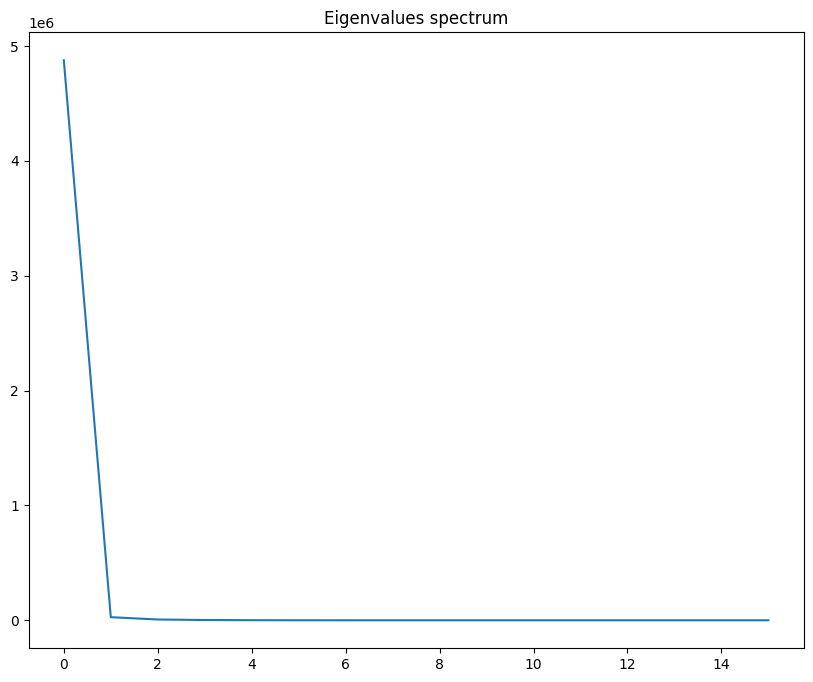

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X) 
plt.figure(figsize=(10,8))
plt.plot(pca.singular_values_)
plt.title("Eigenvalues spectrum")

# Exercise 2
Using the following function, create a one-dimensional dataset of size $N=100$.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,t #normal distribution, t distribution

np.random.seed(44)

In [8]:
N = 100

X = np.concatenate(
    (np.random.standard_t(1, int(0.04*N))-3.5,np.random.normal(5, 1, int(0.48 * N)), np.random.normal(7.5, 1, int(0.48 * N)))
)[:, np.newaxis]

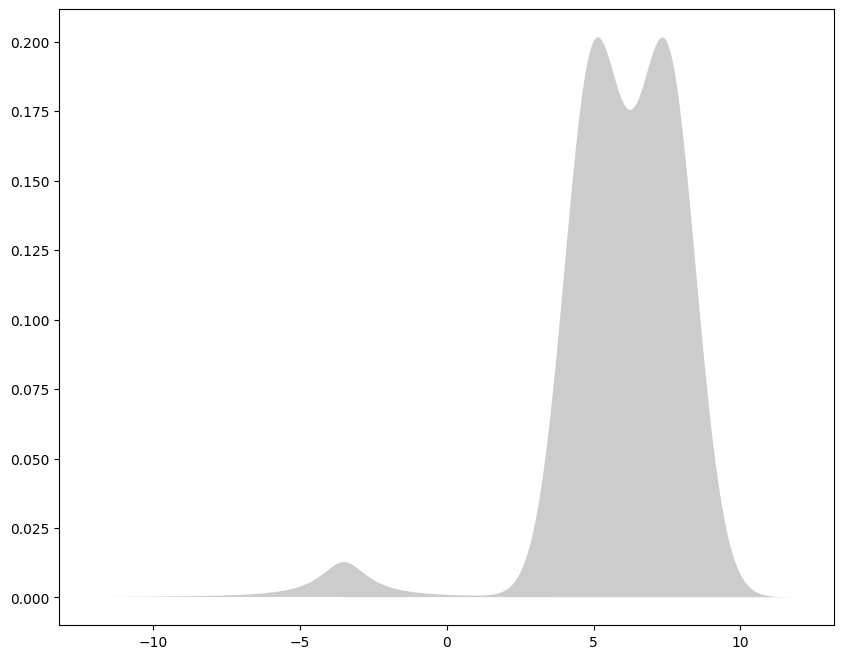

In [9]:
X_plot = np.linspace(-12,12, 1000)[:, np.newaxis]
true_dens = 0.04* t(df=1,loc=-3.5).pdf(X_plot[:, 0]) + 0.48* norm(5, 1).pdf(X_plot[:, 0]) + 0.48*norm(7.5,1).pdf(X_plot[:,0])

fig = plt.figure(figsize=(10,8))
plt.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2)

Compute the density estimation with your implementations of:
- Histogram Density Estimation( Freedman Diaconis rule)
- Kernel Density Estimation (KDE) - Gaussian kernel (Silverman's rule)

In [10]:
# find delta such that (xmax - xmin)/delta is close to 13
q1, q3 = np.percentile(X, [25,75])

# friedman's rule
IQR = q3- q1
delta = (2*IQR)/np.cbrt(X.shape[0])
delta

1.0522038535623301

In [11]:
xmin = X.min()
xmax = X.max()

n_bins = (xmax - xmin)/delta
n_bins

13.475462848359982

In [12]:
# initialize an array to store counts for each bin
counts = np.zeros(14)

for i in range(14):

    # define inf and sup for each interval: [xmin, xmin+delta], [xmin+delta, xmin+2delta],...
    inf = xmin + i*delta
    sup = xmin + (i+1)*delta

    # count how many datapoints there are in each bin
    for j in range(X.shape[0]):
        if X[j]>inf and X[j]< sup:
            counts[i] +=1
counts

array([ 0.,  1.,  1.,  1.,  0.,  0.,  1.,  2., 10., 23., 20., 21., 13.,
        6.])

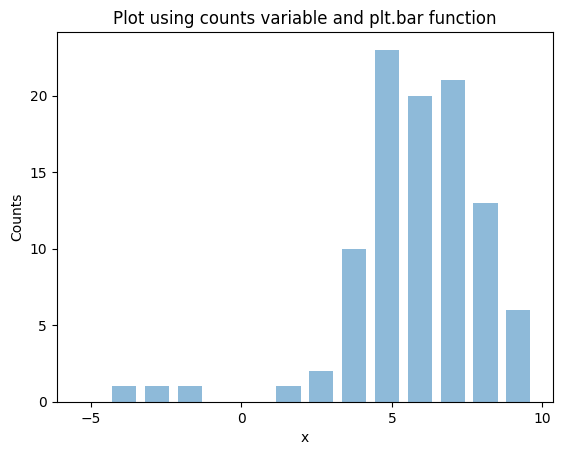

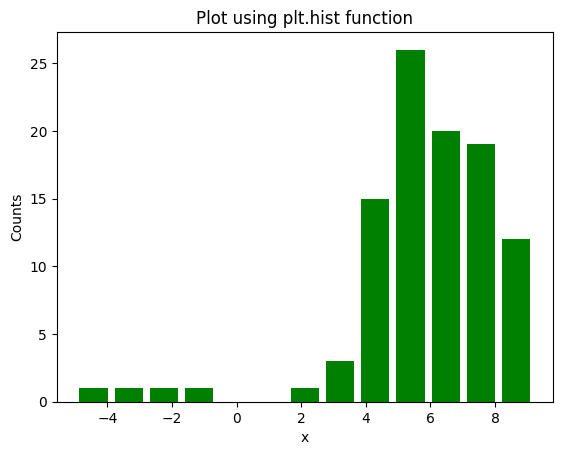

In [13]:
import matplotlib.pyplot as plt

plt.bar(np.linspace(xmin, xmax, 14), counts, alpha=0.5)
plt.xticks(np.linspace(-5, 10, 4))
plt.ylabel('Counts')
plt.xlabel('x')
plt.title('Plot using counts variable and plt.bar function')
plt.show()

plt.hist(x=X, bins=13, rwidth= 0.8, color='green')
plt.ylabel('Counts')
plt.xlabel('x')
plt.title('Plot using plt.hist function')
plt.show()

In [14]:
def Friedman(X):
    # find delta such that (xmax - xmin)/delta is close to 13
    q1, q3 = np.percentile(X, [25,75])

    # friedman's rule
    IQR = q3- q1
    delta = (2*IQR)/np.cbrt(X.shape[0])

    # define number of bins
    xmin = X.min()
    xmax = X.max()

    n_bins = int((xmax - xmin)/delta)

    counts = np.zeros(n_bins)

    for i in range(n_bins):

        # define inf and sup for each interval: [xmin, xmin+delta], [xmin+delta, xmin+2delta],...
        inf = xmin + i*delta
        sup = xmin + (i+1)*delta

        # count how many datapoints there are in each bin
        for j in range(X.shape[0]):
            if X[j]>inf and X[j]< sup:
                counts[i] +=1

    plt.bar(np.linspace(xmin, xmax, n_bins), counts, alpha=0.5)
    plt.xticks(np.linspace(xmin-5, xmax+5, int(n_bins/2)))
    plt.ylabel('Counts')
    plt.xlabel('Bins')
    plt.show()


Density estimation using Silverman's rule

In [15]:
# silverman's rule
h = 0.9*np.min([X.std(), IQR])*(X.shape[0]**(-1/5))

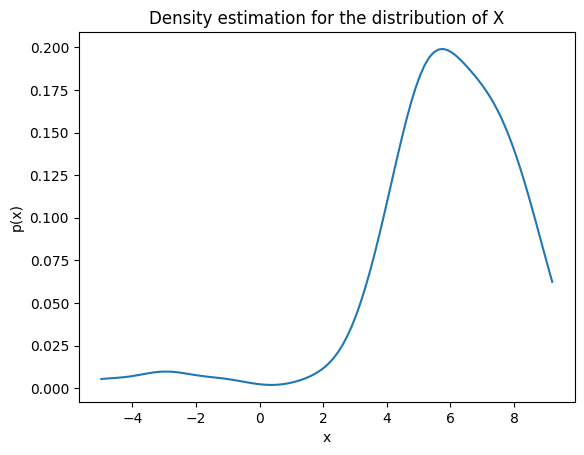

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Create a kernel density estimate using the optimal bandwidth h
def gaussian_kernel(x, x_l, h):
    return (1/np.sqrt(2*math.pi ))*np.exp(-1/(2*(h**2)) * (x-x_l)**2)


# Create a range of x values to evaluate the density at
x_vals = np.linspace(np.min(X), np.max(X), 100)

# Create p_x_vals, where we store the value to build the density function p(x)
p_x_vals = np.zeros(len(x_vals))

# for each point in x_vals (which we use to approximate the density), we compute p(x) as: sum_{l=1 to len(X)} k(x_l, x, h) where x_l is an element of the dataset
for i in range(len(x_vals)):
    tmp = np.array([gaussian_kernel(x_vals[i], X.ravel()[j], h) for j in range(X.shape[0])]).sum()

    # store the evaluated value in p_x_vals. We have the approximation of p(x) plotting x_vals vs p_x_vals
    p_x_vals[i] = tmp * 1/(X.shape[0]*h)


# Create a plot of the density estimate
plt.plot(x_vals, p_x_vals)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.title('Density estimation for the distribution of X')
# Display the plot
plt.show()
